In [2]:
import re
import os

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from matplotlib.patches import Patch
from Bio import motifs
from Bio.Seq import Seq


# Setup

In [3]:
lothar = '/home/enno/uni/SS24/thesis/1_seq_analysis'

if os.getcwd() == lothar:
    pos_df = pd.read_csv('/home/enno/uni/SS24/thesis/data/hendecads/annoted.csv')
    clans_file = '/home/enno/uni/SS24/thesis/1_seq_analysis/5R_hendecad_strict_TMP_full_cd_out_30k1E-3_out.clans'
    fasta_file = '/home/enno/uni/SS24/thesis/1_seq_analysis/5R_hendecad_strict_TMP_full_cd_out.fasta'
else:
    pos_df = pd.read_csv('/ebio/abt1_share/prediction_hendecads/1_repo/2_ss_pred/dataset/annotated_df.csv')
    clans_file = '/ebio/abt1_share/prediction_hendecads/1_repo/1_seq_analysis/5R_hendecad_strict_TMP_full_cd_out_30k1E-3_out.clans'
    fasta_file = '/ebio/abt1_share/prediction_hendecads/0_data/1_seq_analysis/cd_hit_out/5R_hendecad_strict_TMP_full_cd_out.fasta'

In [4]:
# There are 5,851 TMP sequences and 1,607 TMP sequences with at least one 5R hit.
# There are a total of 11,235 5R hits across TMP sequences.
# These 11k hits were condensed to 4,585 hits by CD-HIT

tmp_df = pos_df.loc[(pos_df['reduced_group'] == 'TMP') & (pos_df['5R_hendecad_strict'] > 0)]

In [5]:
def parse_numbers(filename):
    # Extracts the cluster assignment for 5R hits from the .clans file

    clusters = []
    with open(filename, 'r') as file:
       
        for line in file:
            
            if re.match('numbers=', line):
                
                _, num_str = line.split('=')
                numbers = [int(num.strip()) for num in num_str.split(';')[:-1]]

                clusters.append(numbers)
    
    return clusters

In [6]:
def parse_cluster_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    clusters = {}
    current_representative = None

    for line in lines:
        if line.startswith('>Cluster'):
            # This line is the start of a new cluster, so the next line will contain the representative sequence
            current_representative = None
        else:
            # This line contains a sequence
            sequence = line.split(', ')[1].split('...')[0].strip()
            if current_representative is None:
                # This is the first sequence in the cluster, so it's the representative sequence
                current_representative = sequence
            clusters[sequence[1:]] = current_representative[1:]

    return clusters

In [25]:
clusters = parse_cluster_file('5R_hendecad_strict_TMP_full_cd_out.fasta.clstr')

In [8]:
clusters = parse_cluster_file('5R_hendecad_strict_TMP_full_cd_out.fasta.clstr')

print(clusters['WP_090399647.1_[338,393]'])  # Prints '>WP_090399647.1_[331,386]'

WP_090399647.1_[331,386]


In [9]:
numbers = parse_numbers(clans_file)

In [10]:
C1 = numbers[0]
C2 = numbers[1]
C3 = numbers[2]

In [54]:
with open (fasta_file, 'r') as file:
    fasta = file.readlines()

fasta = [line.strip() for line in fasta]

fasta_ids = [sid[1:].split('[')[0][:-1] for sid in fasta[::2]] 
fasta_ixs = [eval(sid[1:].split('_')[-1]) for sid in fasta[::2]]
fasta_seqs = [seq.strip() for seq in fasta[1::2]]

C1_fasta = [fasta_ids[ix] for ix in C1]
C2_fasta = [fasta_ids[ix] for ix in C2]
C3_fasta = [fasta_ids[ix] for ix in C3]
CX_fasta = [fid for ix, fid in enumerate(fasta_ids) if ix not in C1+C2+C3]

C1_seqs = [fasta_seqs[ix] for ix in C1]
C2_seqs = [fasta_seqs[ix] for ix in C2]
C3_seqs = [fasta_seqs[ix] for ix in C3]
CX_seqs = [fid for ix, fid in enumerate(fasta_seqs) if ix not in C1+C2+C3]

C1_stretch = [fasta_ixs[ix] for ix in C1]
C2_stretch = [fasta_ixs[ix] for ix in C2]
C3_stretch = [fasta_ixs[ix] for ix in C3]
CX_stretch = [fid for ix, fid in enumerate(fasta_ixs) if ix not in C1+C2+C3]

C1_data = list(zip(C1_fasta, C1_stretch))
C2_data = list(zip(C2_fasta, C2_stretch))
C3_data = list(zip(C3_fasta, C3_stretch))
CX_data = list(zip(CX_fasta, CX_stretch))


In [12]:
len(C1_fasta) + len(C2_fasta) + len(C3_fasta) + len(CX_fasta)

4589

In [13]:
len(C1_fasta), len(C2_fasta), len(C3_fasta), len(fasta_ids), len(tmp_df['id'])

(1846, 443, 455, 4585, 1607)

In [14]:
len(np.unique(C1_fasta)), len(np.unique(C2_fasta)), len(np.unique(C3_fasta)), len(np.unique(fasta_ids)), len(tmp_df['id'].unique())

(543, 243, 182, 1529, 1540)

In [15]:
len(fasta_ids)

4585

In [42]:
tmp_df = pos_df[(pos_df['reduced_group'] == 'TMP') & 
                (pos_df['5R_hendecad_strict'] > 5)].reset_index(drop=True)

tmp_df['C1'] = 0
tmp_df['C2'] = 0
tmp_df['C3'] = 0
tmp_df['CX'] = 0

c1, c2, c3 = 0, 0, 0
unassigned, unhandled = 0, 0

for ix in range(len(tmp_df)):

    current_seq = tmp_df.iloc[ix]
    current_hits = eval(current_seq['5R_ix_hendecad_strict'])

    # if current_seq['id'] not in fasta_ids:
        # print(f'{current_seq["id"]} not in fasta_ids')
        # continue

    for hit_ix in current_hits:
        
        # this is a too lose check condition
        # id and hit_ix not only need to be in Ci but in the very same order
        if (current_seq['id'], list(hit_ix)) in C1_data:   
            tmp_df.loc[ix, 'C1'] += 1
            c1 += 1
        elif (current_seq['id'], list(hit_ix)) in C2_data:
            tmp_df.loc[ix, 'C2'] += 1
            c2 += 1
        elif (current_seq['id'], list(hit_ix)) in C3_data:
            tmp_df.loc[ix, 'C3'] += 1
            c3 += 1
        elif (current_seq['id'], list(hit_ix)) in CX_data:
            tmp_df.loc[ix, 'CX'] += 1
            unassigned += 1
        else:
            representative = clusters[current_seq['id'] + '_' + str(list(hit_ix)).replace(' ', '')].split('[')
            rep_id = representative[0][:-1]
            rep_ix = eval('[' + representative[1])
            
            if (rep_id, rep_ix) in C1_data:
                tmp_df.loc[ix, 'C1'] += 1
                c1 += 1
            elif (rep_id, rep_ix) in C2_data:
                tmp_df.loc[ix, 'C2'] += 1
                c2 += 1
            elif (rep_id, rep_ix) in C3_data:
                tmp_df.loc[ix, 'C3'] += 1
                c3 += 1
            elif (rep_id, rep_ix) in CX_data:
                tmp_df.loc[ix, 'CX'] += 1
                unassigned += 1
            else:
                unhandled += 1

            
            # print("unhandled hit")
            # find representative and annotate accordingly!

tmp_df['C1_norm'] = tmp_df['C1'] / tmp_df['5R_hendecad_strict']
tmp_df['C2_norm'] = tmp_df['C2'] / tmp_df['5R_hendecad_strict']
tmp_df['C3_norm'] = tmp_df['C3'] / tmp_df['5R_hendecad_strict']
tmp_df['CX_norm'] = tmp_df['CX'] / tmp_df['5R_hendecad_strict']

c1, c2, c3, unassigned, c1 + c2 + c3 + unassigned, unhandled

(4143, 457, 1426, 2957, 8983, 0)

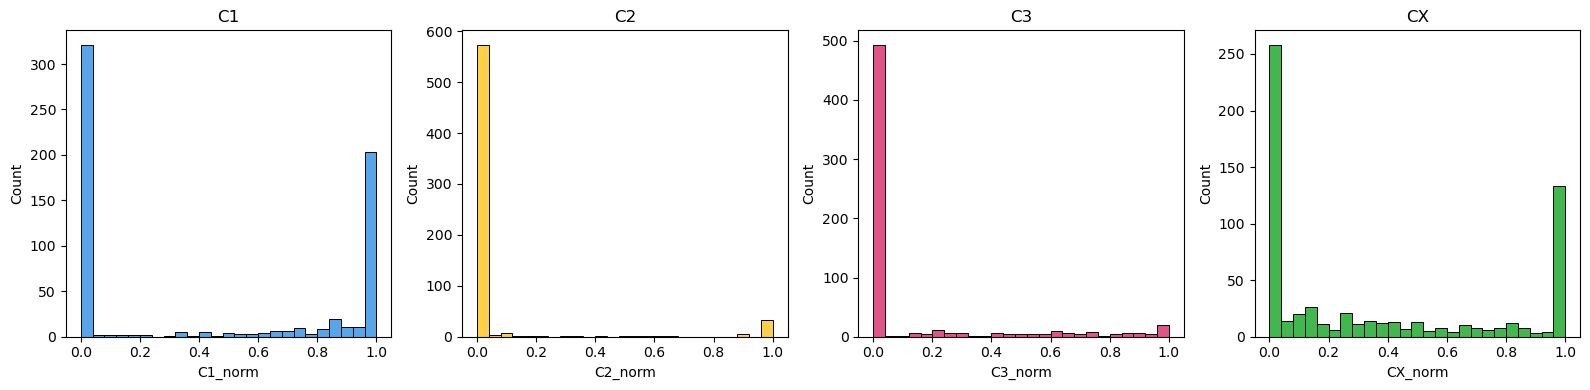

In [43]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

sns.histplot(tmp_df['C1_norm'], bins=25, ax=axes[0], color='#1E88E5', label='C1')
sns.histplot(tmp_df['C2_norm'], bins=25, ax=axes[1], color='#FFC107', label='C2')
sns.histplot(tmp_df['C3_norm'], bins=25, ax=axes[2], color='#D81B60', label='C3')
sns.histplot(tmp_df['CX_norm'], bins=25, ax=axes[3], color='#00A012', label='CX')

axes[0].set_title('C1')
axes[1].set_title('C2')
axes[2].set_title('C3')
axes[3].set_title('CX')

plt.tight_layout()
plt.show()

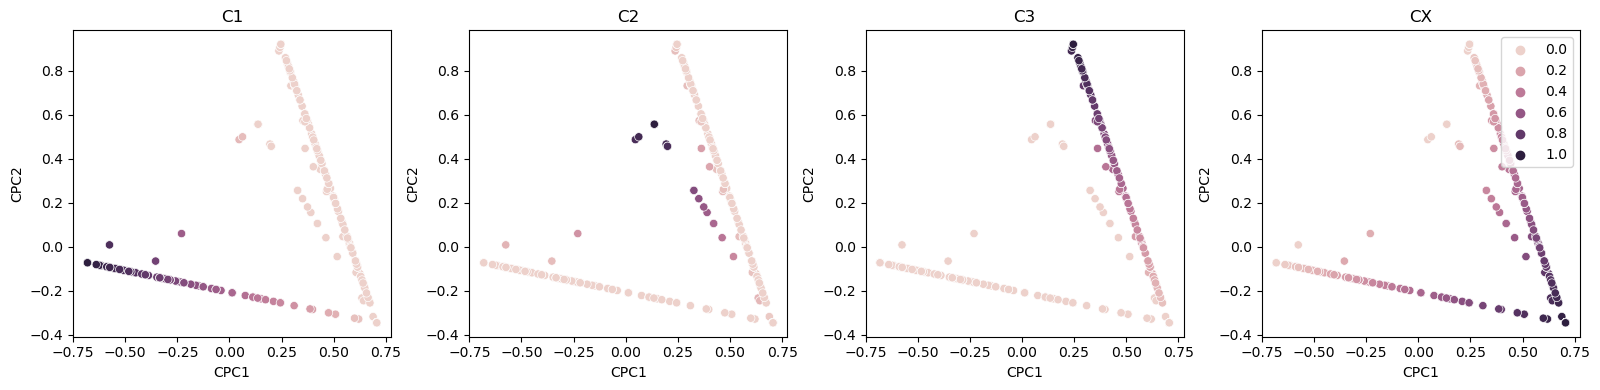

In [45]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)

data_pca = pca.fit_transform(tmp_df[['C1_norm', 'C2_norm', 'C3_norm', 'CX_norm']])
tmp_df[['CPC1', 'CPC2']] = data_pca

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

sns.scatterplot(x='CPC1', y='CPC2', data=tmp_df, ax=axes[0], hue='C1_norm')
sns.scatterplot(x='CPC1', y='CPC2', data=tmp_df, ax=axes[1], hue='C2_norm')
sns.scatterplot(x='CPC1', y='CPC2', data=tmp_df, ax=axes[2], hue='C3_norm')
sns.scatterplot(x='CPC1', y='CPC2', data=tmp_df, ax=axes[3], hue='CX_norm')


axes[0].set_title('C1')
axes[1].set_title('C2')
axes[2].set_title('C3')
axes[3].set_title('CX')

axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[3].legend(loc='upper right')

plt.tight_layout()
plt.show()


# CLANS

In [57]:
# Get cluster assignments for each 5R hit
cl = []
for cx in range(len(fasta[::2])):
    if cx in C1:
        cl.append(0)
    elif cx in C2:
        cl.append(1)
    elif cx in C3:
        cl.append(2)
    else:
        cl.append(3)

In [91]:
test_id = "WP_204698829.1"
test_seq = tmp_df[tmp_df['id'] == test_id]
test_ixs = eval(test_seq['5R_ix_hendecad_strict'].values[0])

test_seq[['id', 'seq', '5R_hendecad_strict', 'C1', 'C2', 'C3', 'CX', 'C1_norm', 'C2_norm', 'C3_norm', 'CX_norm']]

,id,seq,5R_hendecad_strict,C1,C2,C3,CX,C1_norm,C2_norm,C3_norm,CX_norm
1,WP_204698829.1,MALRELEVEIGFnidtgvlddmnesidsamsgldalgqsgddmgag...,22,22,0,0,0,1.0,0.0,0.0,0.0


In [98]:
with open(clans_file, 'r') as file:
    data = file.readlines()

data = [line.strip() for line in data]

first_pos = 9228
last_pos = 13813

pos = [(float(x.split()[2]), float(x.split()[1])) for x in data[first_pos:last_pos]]

x = [int(x[0]) for x in pos]
y = [int(x[1]) for x in pos]
cl = cl

hit_df = pd.DataFrame({'id': fasta_ids, 'x': x, 'y': y, 'cl': cl})

In [194]:
# randomly sample 10 hits from each cluster
sample = tmp_df.groupby('cluster_int').apply(lambda x: x.sample(10)).reset_index(drop=True)
test_ids = sample['id'].unique()

sample = hit_df[hit_df['id'].isin(test_ids)]

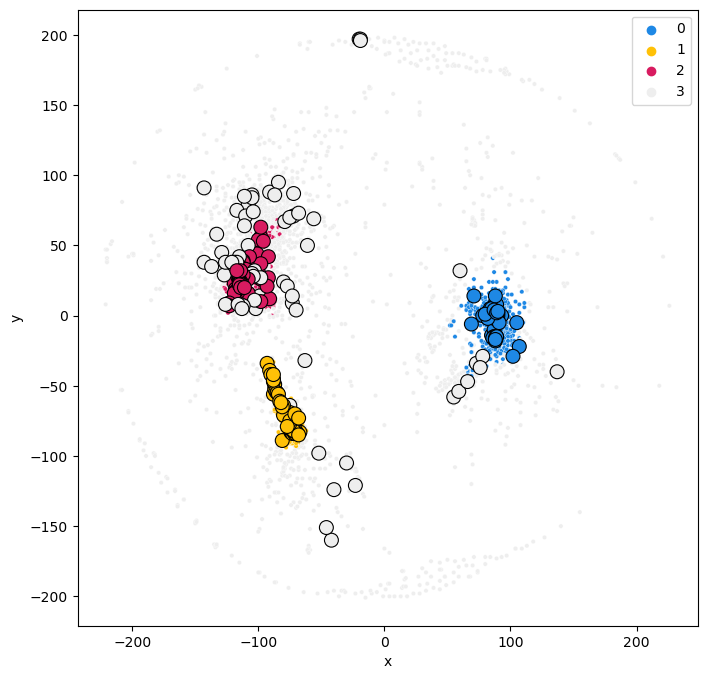

In [198]:
# hit_df[hit_df['id'] == test_id]

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=hit_df, x='x', y='y', hue='cl', palette=['#1E88E5', '#FFC107', '#D81B60', '#EEEEEE'], s=10)
sns.scatterplot(data=sample, x='x', y='y', hue='cl', palette=['#1E88E5', '#FFC107', '#D81B60', '#EEEEEE'], s=100, edgecolor='black')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:4], labels=labels[:4])
plt.show()

# Sequence Logos

In [130]:
from Bio import SeqIO

with open('/home/enno/uni/SS24/thesis/1_seq_analysis/C1.fasta', 'r') as f:
    C1_records = list(SeqIO.parse(f, 'fasta'))

with open('/home/enno/uni/SS24/thesis/1_seq_analysis/C2.fasta', 'r') as f:
    C2_records = list(SeqIO.parse(f, 'fasta'))

with open('/home/enno/uni/SS24/thesis/1_seq_analysis/C3.fasta', 'r') as f:
    C3_records = list(SeqIO.parse(f, 'fasta'))

In [137]:
def cut_sequences(records, C, R=5):
    
    with open(f'/home/enno/uni/SS24/thesis/1_seq_analysis/C{C}_cut.fasta', 'w') as f:
        for seq in records:
            name = seq.description
            seq = str(seq.seq)
            
            for i in range(R):
                
                f.write(f'>{name}_{i}\n')
                f.write(seq[i*11:(i+1)*11] + '\n')

cut_sequences(C1_records, '1')
cut_sequences(C2_records, '2')
cut_sequences(C3_records, '3')